## AEGEAN Task
Here I show the results of my analysis in response to the task given by the data team of AEGEAN. The task was divided into three sub-tasks, each with more or less open-ended questions. Because of the size and abundance of the data in this dataset, there are plenty of ways to explore, analyse, and transform the data. Therefore, I would like to stress that the analysis presented here is far from complete, and do not reflect the full and thorough analysis that could be performed with more time. Instead, as required by the task, this analysis is better intended at showing my analytical mindset. Nevertheless, I will show that, even with this slightly overlooked analysis, some strong pre-conclusion can be drawn on the reasons behind aircraft delays.

# IMPORTANT
If opened on a new Kaggle session, the data needs to be linked. To do this,
1. click on "add data" at the top right of the page.
2. click on the "search by URL"
3. enter in the search bar the url: https://www.kaggle.com/datasets/usdot/flight-delays
4. click add on the 2015 flights dataset.

With the data embedded, the notebook should now run.

# Task 1
> We would like you to left join flights with airlines and airports using their respective
IATA code. Please describe the resulting dataset ‘flights_extended’: Number of rows, null
values if any. Also, please describe any cleaning processes you may find useful or necessary.

To do this, we first link the data to this notebook using the Kaggle dashboard, and define dataframes which will allow us to explore and transform the data.

In [1]:
import pandas as pd

flights = pd.read_csv('/kaggle/input/flight-delays/flights.csv')
airlines = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
airports = pd.read_csv('/kaggle/input/flight-delays/airports.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The dataframe (herafter DF) "flights" contains information (see below for details) on a list of USA-based flights for 2015. The DFs "airports" and "airlines" contain information on a list of US-based airports and airlines that can be identified via their corresponding IATA codes. We note that we have a warning about mixed types in two columns. However, this is not gonna be problematic for us, so we just ignore the warning.

As shown in the next cell, to perform task 1, we first left-join "flights" and "airlines" on the 'AIRLINE' and 'IATA_CODE' columns. We also add suffixes '_left' and '_right' for if two columns have the same name. We then drop the column 'AIRLINE_left', since it contains the airline IATA codes, also present in the right-hand side table, and we rename the column 'AIRLINE_right' to 'AIRLINE', which contains the full name of the airline. Finally, the column 'IATA_CODE' is renamed as 'IATA_CODE_AIRLINE' to not confuse with the IATA code of the airports later on. The left-joint DF "flights_airlines" is created.

We then left-join the DF "flights_airlines" and "airports" on the 'ORIGIN_AIRPORT' and 'IATA_CODE' columns. We chose to use the origin, instead of the destination airports, since we will be interested in aircraft delays at departure times. Finally, the column 'IATA_CODE' is renamed as 'IATA_CODE_AIRPORT', and all of the columns related to the right-hand side table (i.e. to the airports) are renamed with a suffix '_ORIGIN'. The DF "flights_extended" is created.

In [2]:
# Left-join the flights and airlines DFs.
flights_airlines = pd.merge(flights,airlines,
                            left_on='AIRLINE',
                            right_on='IATA_CODE',
                            how='left',
                            suffixes=('_left', '_right'))

# Drop the 'AIRLINE_left' column since repeats IATA_CODE, 
# and rename 'AIRLINE_right' to 'AIRLINE' and 'IATA_CODE' to 'IATA_CODE_AIRLINE'.
flights_airlines = flights_airlines.drop(['AIRLINE_left'], 
                                         axis=1).rename(columns={'AIRLINE_right':'AIRLINE', 
                                                                 'IATA_CODE':'IATA_CODE_AIRLINE'})

# Left join on the origin airport since we will be looking at departure delays.
flights_extended = pd.merge(flights_airlines,airports,
                            left_on='ORIGIN_AIRPORT',
                            right_on='IATA_CODE',
                            how='left',
                            suffixes=('_left', '_right'))

# Rename 'IATA_CODE' to 'IATA_CODE_AIRPORT', and all keys related to the airport with added suffix '_ORIGIN', 
# to make clear that these are the origin airport.
flights_extended = flights_extended.rename(columns={'IATA_CODE':'IATA_CODE_AIRPORT', 
                                                    'AIRPORT': 'AIRPORT_ORIGIN',
                                                    'CITY': 'CITY_ORIGIN',
                                                    'STATE': 'STATE_ORIGIN',
                                                    'COUNTRY': 'COUNTRY_ORIGIN',
                                                    'LATTITUDE': 'LATTITUDE_ORIGIN',
                                                    'LONGITUDE': 'LONGITUDE_ORIGIN'})

In [3]:
# Displays the info of the DF.
flights_extended.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 39 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   FLIGHT_NUMBER        5819079 non-null  int64  
 5   TAIL_NUMBER          5804358 non-null  object 
 6   ORIGIN_AIRPORT       5819079 non-null  object 
 7   DESTINATION_AIRPORT  5819079 non-null  object 
 8   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 9   DEPARTURE_TIME       5732926 non-null  float64
 10  DEPARTURE_DELAY      5732926 non-null  float64
 11  TAXI_OUT             5730032 non-null  float64
 12  WHEELS_OFF           5730032 non-null  float64
 13  SCHEDULED_TIME       5819073 non-null  float64
 14  ELAPSED_TIME         5714008 non-null  float64
 15

There are ~5.8 million entries in the DF "flights_extended", each corresponding to a single flight in 2015. For all of these, we further have the origin and destination airports, the scheduled departure time, and whether the aircraft was cancelled or diverted. A potential delay at departure is provided for 98% of the flights which is almost complete. We note that some origin airports (roughly 10% of the full dataset) were not listed into the 'IATA_CODE' of the DF "airports", since we have some null values in the AIRPORT section of the full extended DF. There is further information on the reasons behind the delays, but only for ~20% of all the flights, which is therefore unlikely to be usefull for our task.

"flights_extended" is the DF that we will be using to further explore the origin of the delays at the departure of aircrafts.

# Task 2
> We would like to perform an analysis in the top 10 airports in terms of departure
delay. Please create a metric to rank each airport according to the average number of
aircraft that departed from that airport having a DEPARTURE_DELAY > 15 mins. Please
describe if such a metric would be efficient to compare airports and include any suggestion
to improve such a comparison.

For this task, we aim at ranking US airports in terms of their departure delays in the year 2015, and select the top 10 (worst). To rank airports, we use the average monthly fraction of delayed aircrafts, calculated by taking the number of delayed planes (>15 mins) for each month and each airport, divided by the total number of planes in the same month and airport, and averaged accross months. So for each airport, we obtain the monthly average fraction of delayed planes.

Prior to this, we drop airports with no defined 'IATA_CODE'. In addition, we notice that the DF "flights_extended" contains many small airports with barely any flights. These are likely to be private airports or airfields, and cannot be really compared against main passenger airports. To select big (passenger) airports we only kept airports with at least 10 flights a day, which corresponds to 3650 flights per year. This remains a quite small number of flights for airports that can be found in major US cities, yet allows us to remove the smaller airports.

In [4]:
import numpy as np

# We remove the rows that do not have any defined origin airport.
flights_extended = flights_extended.dropna(subset=['IATA_CODE_AIRPORT'])

# Many airports have barely any flights. They must be very small airports. To select big (passenger) airports
# we select only those with at least 10 flights a day, which is 3650 flights for the year.
total_nflights_per_airport = flights_extended.groupby('IATA_CODE_AIRPORT')\
                                             .agg({'FLIGHT_NUMBER':'count'})\
                                             .reset_index().rename(columns={'FLIGHT_NUMBER':'N_FLIGHTS'})

# Here we get the list of all the "major" airport, where major is defined above.
airports_list = total_nflights_per_airport['IATA_CODE_AIRPORT'][total_nflights_per_airport['N_FLIGHTS']>3650.].values.tolist()

# We now calculate the average number of flights a month, 
# of which, how many are delayed by more than 15 mins.
months_list = np.unique(flights_extended['MONTH']).tolist()

av_flight_month = []
av_flight_delayed_month = []
# Loop over the major airports
for airport in airports_list:
    # DF of a given airport
    df_airport = flights_extended[flights_extended['IATA_CODE_AIRPORT'] == airport]
    
    n_flights = []
    n_flights_delayed = []
    # Loop of the months
    for month in months_list:
        # DF of the airport and for a given month
        df_airport_month = df_airport[df_airport['MONTH'] == month]
        
        # Get the total number of flights per months from that airport
        n_flights.append(len(df_airport_month))
        
        # Of which that are delayed by more than 15 mins.
        n_flights_delayed.append(len(df_airport_month[df_airport_month['DEPARTURE_DELAY'].values > 15.]))

    # Average number of flights a month for a given airport
    av_flight_month.append(np.mean(n_flights))

    # Average number of flights a month delayed by more than 15 mins for a given airport
    av_flight_delayed_month.append(np.mean(n_flights_delayed))

av_flight_month = np.array(av_flight_month)
av_flight_delayed_month = np.array(av_flight_delayed_month)
frac_delayed_flight_month = np.round(av_flight_delayed_month/av_flight_month*100.,2)

The variable 'frac_delayed_flight_month' contains the average fraction of monthly delayed flights per airports, for airports listed in the 'airports_list'.
To rank these airport in terms of their monthly delay, we create a DF containing these columns and sort it by delay.

The top 10 airport for highest monthly average delays of more than 15 mins are:


['Baltimore-Washington International Airport',
 'Dallas Love Field',
 'Denver International Airport',
 'Newark Liberty International Airport',
 'William P. Hobby Airport',
 'LaGuardia Airport (Marine Air Terminal)',
 'Chicago Midway International Airport',
 'Miami International Airport',
 "Chicago O'Hare International Airport",
 'Palm Beach International Airport']

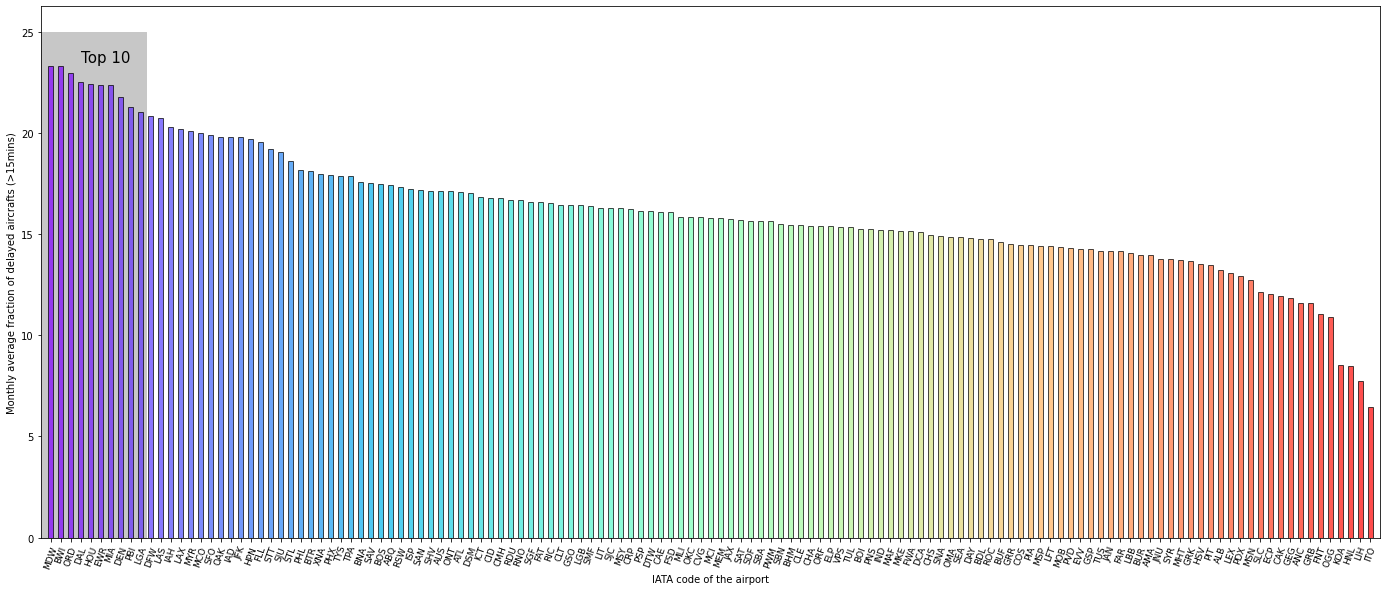

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

df_major_airport_delay = pd.DataFrame({'AIRPORT_NAME': airports_list, 
                                       'FRAC_DELAYED': frac_delayed_flight_month}).sort_values(by = ['FRAC_DELAYED'],
                                                                                               ascending = False)

# Plot the fraction of monthly delayed flights for the major airports.
fig, axs = plt.subplots(figsize = (20, 9))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.06, right = 0.99, bottom = 0.10, top = 0.92)

# Define the colour map
cm_subsection = np.linspace(0., 1., len(df_major_airport_delay))
colours = [cm.rainbow(x) for x in cm_subsection]

axs.bar(df_major_airport_delay['AIRPORT_NAME'].values, df_major_airport_delay['FRAC_DELAYED'], color = colours, edgecolor = 'k', alpha = 0.7, width = 0.5, linewidth = 1)
axs.fill_between([-1,9.5], [0,0],[25,25], color = '#c7c7c7', alpha = 1, zorder = 0)
axs.set_ylabel('Monthly average fraction of delayed aircrafts (>15mins)')
axs.text(3., 23.5, 'Top 10', fontsize = 15)
axs.set_xlabel('IATA code of the airport')
axs.tick_params(axis = 'x', labelrotation=70, labelsize = 9)
axs.set_xlim([-1., 133])
fig.savefig('/kaggle/working/rank_delay.pdf')

# Name the top 10.
IATA_CODE_DELAY = df_major_airport_delay['AIRPORT_NAME'].values[0:10]
delay_airport_name = airports.loc[airports['IATA_CODE'].isin(IATA_CODE_DELAY)]['AIRPORT'].values

print('The top 10 airport for highest monthly average delays of more than 15 mins are:')
[airport for airport in delay_airport_name]

The figure above shows the monthly average fraction of delayed flights for the 133 airports that have been selected as "major" (i.e. with more than 10 flights a day), and the worst airports are located at the left-hand side of the graph. 

<!-- The resolution of this figure (and all others too) is low on this notebook, and it is difficult to read, compared to when displayed locally on my laptop. I would normally try to fix this, but I prefer using my time to do more analysis at this particular occasion. -->

We note that the decision of the top 10 is quite arbitrary since that the monthly average fraction is smoothly changing from airport to airport. We further note that the top 10 worst airports for monthly delays show an average fraction of delayed flight between 20 and 25 percent for the year 2015, while the best airports show an average fraction of delayed flight between 5 and 10 percent. The airports that are ranked as top 10 are all major international well-known airports connecting major US cities.

The metric itself is robust since it calculates a fraction of flights, instead of a number of flights, therefore accounting for the fact that airports have different numbers of flights per month.

We could have done the daily fraction, but this is a highly unstable number, and since averages are sensitive to extreme values, the daily fraction would not reflect the overall behaviour of the airport in terms of delays of more than 15 mins.

Doing it per year intead would have had the opposite effect and could have smoothed out some strong and lengthy delays in some airport.

It is difficult to say whether this is a good metric to compare between airports, but by using fractions instead of absolute numbers it sure is better, since normalising to the monthly number of planes. To improve the metric, we could have split the dataset by lattitudes to account for the weather differences between airports in the south and the north of the USA. We could have further ranked airports based on average delays (i.e. selecting those with the longest ones), instead of using a single 15 mins cut.

# Task 3
> We would like to find the association, if any, between these top 10 airports and the
aircraft that had no previous arrival delay (ARRIVAL_DELAY < 15) on a given day but they had
arrival delay > 15 mins as soon as they departed from these airports. Please create any
metrics and plots and use any technique you deem necessary to indicate the potential
existence of such a phenomenon.

To perform task 3, we start by creating the DF "flights_delay" which is a subset of the "flights_extended" DF, but only containing the top 10 airports that are worst for delays, as selected in Task 2.

In [6]:
flights_delay = flights_extended.loc[flights_extended['IATA_CODE_AIRPORT'].isin(IATA_CODE_DELAY)]

Let's have a quick look to where these airports are located in the US. In fact, the US covers a large range of lattitudes, and some airports in the north can experience more adverse weather in the winter, when compared to airports in the south.

     |████████████████████████████████| 862 kB 5.2 MB/s            
     |████████████████████████████████| 15.7 MB 54.8 MB/s            
     |████████████████████████████████| 30.5 MB 33.4 MB/s            
     |████████████████████████████████| 219 kB 50.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=5f230e01a71d9272d46bf13c51e06849bcab7cfe38c6babbf50cacc3f271c4a5
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: pyshp
    Found existing installation: pyshp 2.2.0
    Uninstalling pyshp-2.2.0:

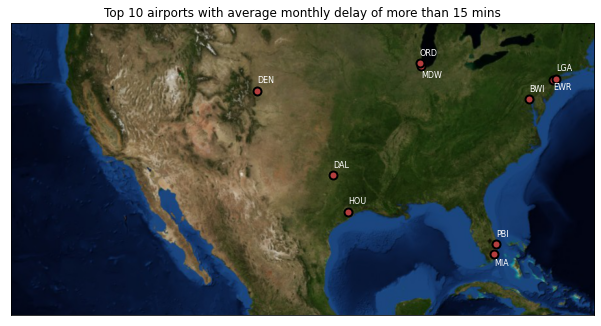

In [7]:
try:
    from mpl_toolkits.basemap import Basemap
except:
    !pip install basemap
    from mpl_toolkits.basemap import Basemap

airports_delay = airports.loc[airports['IATA_CODE'].isin(IATA_CODE_DELAY)]
longitudes = airports_delay["LONGITUDE"].tolist()
latitudes = airports_delay["LATITUDE"].tolist()

fig, ax = plt.subplots(figsize=(10,10))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.16, right = 0.97, bottom = 0.12, top = 0.98)

plt.title("Top 10 airports with average monthly delay of more than 15 mins")

m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=45, 
            llcrnrlon=-130, urcrnrlon=-70)
m.bluemarble()
x, y = m(longitudes, latitudes)

m.plot(x,y,'o', ms = 8, mew = 2, mec = 'k', mfc = '#b53e3e')

i = 0
for name_i, x_i, y_i in zip(airports_delay['IATA_CODE'].values, x, y):
    if i == 3:
        plt.annotate(name_i, xy = (x_i, y_i), xytext = (0,-10), textcoords = 'offset points', 
                     color = '#ffffff', fontsize = 8)
    elif i == 6:
        plt.annotate(name_i, xy = (x_i, y_i), xytext = (0,-12), textcoords = 'offset points', 
                     color = '#ffffff', fontsize = 8)
    elif i == 7:
        plt.annotate(name_i, xy = (x_i, y_i), xytext = (0,-12), textcoords = 'offset points', 
                     color = '#ffffff', fontsize = 8)
    else:
        plt.annotate(name_i, xy = (x_i, y_i), xytext = (0,8), textcoords = 'offset points', 
                     color = '#ffffff', fontsize = 8)
    i += 1

fig.savefig('/kaggle/working/map_airport.pdf')

****[On the first run of cell 7, installing basemap seems to create a lot of warnings due to package issues. One can run a second time cell 7 to remove them.]****

We note that these 10 airports are scattered accross several lattitudes in the US. Therefore, adverse winter conditions such as heavy snow fall seen in cities like New-York or Chicago does not appear to be the primordial factor for such important delays. Instead, there might be an east-west dichotomy, with the top 10 airports mostly located toward the east side of the US. Perhaps, if the east side is more populated than the west side, these delays could be due to congestion.

With no obvious reasons to believe that these delays are due to location, we look a bit more in details to each of these airports and why they might be experiencing larger delays on average.

As suggested in the task, we first remove those aircrafts that arrived with a large delay, likely to cause further delay at the following departure.

In [8]:
flights_delay_arrnodelay = flights_delay[flights_delay['ARRIVAL_DELAY'].values < 15]

We note that we have some columns in the DF that could indicate the reasons behind the delays (i.e. AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, and WEATHER_DELAY). However, for these airports, after extensive checks, they only have null values, and cannot help in undertanding better the reasons behind the delays.

To better understand the reasons behind the delays, we first check whether the delay is seasonal, by plotting the daily fraction of delayed aircrafts for each of these airports.

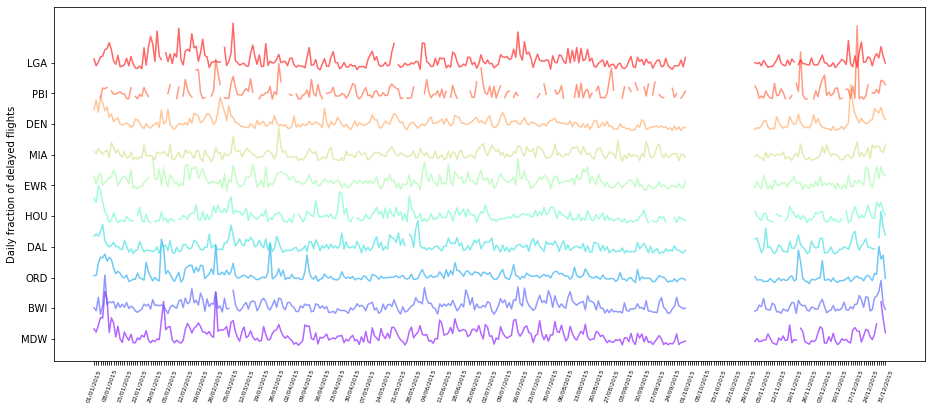

In [9]:
from datetime import datetime, date, timedelta

fig, axs = plt.subplots(figsize = (13, 6))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.06, right = 0.99, bottom = 0.10, top = 0.92)

year_2015 = []
start_date = date(2015,1,1)
end_date = date(2015,12,31)
delta = timedelta(days=1)
while start_date <= end_date:
    year_2015.append(start_date.strftime("%d/%m/%Y"))
    start_date += delta
year_2015 = np.array(year_2015)

cm_subsection = np.linspace(0., 1., len(IATA_CODE_DELAY))
colours = [cm.rainbow(x) for x in cm_subsection]

frac_delayed_flight_combined = []
# Loop over all the 10 airports.
for index_i, IATA_CODE in enumerate(IATA_CODE_DELAY):

    # Delay airport data frame sorted by date.
    df_airport = flights_delay_arrnodelay[flights_delay_arrnodelay['IATA_CODE_AIRPORT'] == IATA_CODE].sort_values(['YEAR', 'MONTH', 'DAY'])
    
    # We create a DF for the aggregate total number of flights per day
    total_flights_per_day = df_airport.groupby(['YEAR', 'MONTH', 'DAY'])\
                                      .agg({'FLIGHT_NUMBER':'count'})\
                                      .reset_index().rename(columns={'FLIGHT_NUMBER':'N_FLIGHTS'})
    
    # We add some timestamps.
    timestamp = []
    for row_i in total_flights_per_day.iterrows():
        date_i = str(row_i[1][2])+'/'+str(row_i[1][1])+'/'+str(row_i[1][0])+' - 00:00:00'
        timestamp.append(datetime.timestamp(datetime.strptime(date_i, "%d/%m/%Y - %H:%M:%S")))

    total_flights_per_day = total_flights_per_day.assign(timestamp=timestamp)
    
    # We repeat the same but for the delayed flights
    df_airport_delayed = df_airport[df_airport['DEPARTURE_DELAY'] > 15.]
    total_delayed_flight_per_day = df_airport_delayed.groupby(['YEAR', 'MONTH', 'DAY']).agg({'FLIGHT_NUMBER':'count'}).reset_index().rename(columns={'FLIGHT_NUMBER':'N_FLIGHTS'})

    timestamp = []
    for row_i in total_delayed_flight_per_day.iterrows():
        date_i = str(row_i[1][2])+'/'+str(row_i[1][1])+'/'+str(row_i[1][0])+' - 00:00:00'
        timestamp.append(datetime.timestamp(datetime.strptime(date_i, "%d/%m/%Y - %H:%M:%S")))

    total_delayed_flight_per_day = total_delayed_flight_per_day.assign(timestamp=timestamp)
    
    # We merge the two DFs containing the total and delayed daily flights 
    total_flights_extended = pd.merge(total_flights_per_day,
                                      total_delayed_flight_per_day,
                                      left_on='timestamp',
                                      right_on='timestamp',
                                      how='left', 
                                      suffixes=('_total', '_delayed'))

    # We transform the timestamps into dates to compare against the year, and 
    # calculate for each of the day of the year 2015 the fraction of delayed flights.
    date_time = [datetime.fromtimestamp(date_i).strftime('%d/%m/%Y') for date_i in total_flights_extended['timestamp'].values]
    frac_delayed_flight = []
    for day_i in year_2015:
        o = np.where(np.array(date_time) == day_i)[0]
        if len(o) > 0.:
            frac_delayed_flight.append((total_flights_extended['N_FLIGHTS_delayed'].values[o]/total_flights_extended['N_FLIGHTS_total'].values[o])[0])
        else:
            # if no data for the day, we just fill the value with a nan
            frac_delayed_flight.append(np.nan)

    # We plot the daily fraction
    frac_delayed_flight = np.array(frac_delayed_flight)
    axs.plot(year_2015, frac_delayed_flight + index_i/5., '-', color = colours[index_i], alpha = 0.6)
    
    # We save the fraction of delayed flight of each airport in a list,
    # after changing the nan by zeros.
    frac_delayed_flight[frac_delayed_flight != frac_delayed_flight] = 0.
    frac_delayed_flight_combined.append(frac_delayed_flight)

# We plot the results
fig.canvas.draw()

axs.set_yticks(np.arange(0, (len(IATA_CODE_DELAY))/5., 1/5.)+0.05)
labels = [item.get_text() for item in axs.get_yticklabels()]
labels = IATA_CODE_DELAY
axs.set_yticklabels(labels)

axs.set_ylabel('Daily fraction of delayed flights')
axs.tick_params(axis = 'x', labelrotation=70, labelsize = 6)
n = 7  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
fig.savefig('/kaggle/working/daily_delayed_flight.pdf')

Throughout the year, the fraction of delayed aircrafts appears pretty flat and random for all of the 10 airports. There is also somewhat missing data around November for all of these airports. Having a closer look, we note that some airports show an increasing trend toward winter (e.g. MDW, DEN, HOU) when compared to others (e.g. MIA). This might be due to weather since the one showing a "bump" toward winter tend to be located in the North. However, it cannot explains the large random spikes of delays observed throughout the year.

There is no obvious correlation between the spikes accross these airports. To test this further, we can average over all of the 10 airports, and see if some times of the years are more prone to delays compared to others, since that spikes that are on top of each others will add up.

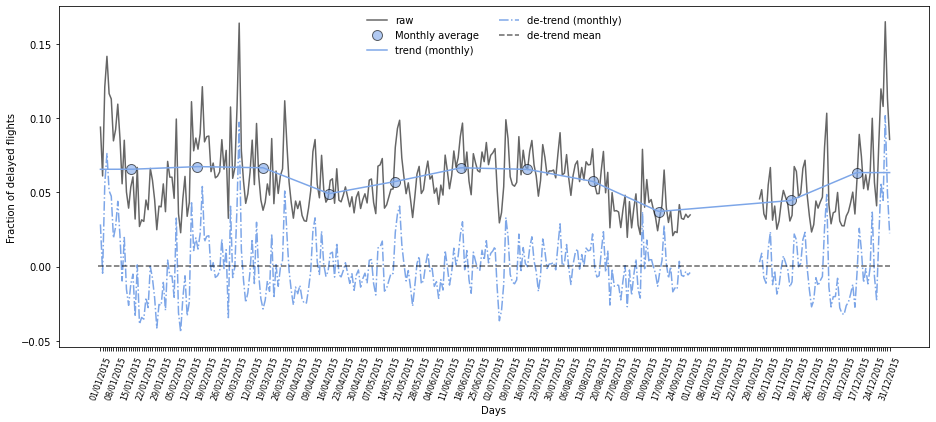

In [10]:
# define the mean across all of the 10 airports
median_delayed_flight = np.median(frac_delayed_flight_combined, axis = 0)
x_year = np.arange(0, len(median_delayed_flight))+1

fig, axs = plt.subplots(figsize = (13, 6))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.06, right = 0.99, bottom = 0.16, top = 0.95)

# Define monthly bins for monthly averages.
d_i = 365./12.
x_month = np.arange(0, len(x_year), d_i)+d_i/2.
monthly_average = np.array([np.mean(median_delayed_flight[(x_year > month_i-d_i/2.) & (x_year < month_i+d_i/2.)]) for month_i in x_month])

monthly_average_interp = np.interp(x_year, x_month[monthly_average != 0.], monthly_average[monthly_average != 0.])

median_delayed_flight[median_delayed_flight == 0.] = np.nan

# De-trend the mean average of the fraction of delay by the monthly average
y_detrend = median_delayed_flight - monthly_average_interp

axs.plot(x_year, median_delayed_flight, '-', color = 'k', alpha = 0.6, label = 'raw')
axs.plot(x_month[monthly_average != 0.], monthly_average[monthly_average != 0.], 
         'o', alpha = 0.6, mec = 'k', mfc = '#7da6e8', ms = 10, label = 'Monthly average')
axs.plot(x_year, monthly_average_interp, '-', color = '#7da6e8', alpha = 1, label = 'trend (monthly)')

axs.plot(x_year, y_detrend, '-.', color = '#7da6e8', alpha = 1., label = 'de-trend (monthly)')
axs.plot([0., 365.], [np.nanmean(y_detrend), np.nanmean(y_detrend)], 'k--', alpha = 0.6, label = 'de-trend mean')

axs.set_xticks(x_year)
labels = [item.get_text() for item in axs.get_yticklabels()]
labels = year_2015
axs.tick_params(axis = 'x', labelrotation=70, labelsize = 8)
n = 7  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
axs.set_xticklabels(labels)

axs.set_ylabel('Fraction of delayed flights')
axs.set_xlabel('Days')
plt.legend(frameon = False, ncol = 2)
fig.savefig('/kaggle/working/daily_delayed_flight_detrend.pdf')

In the figure above, the grey line labelled "raw" shows the same as the previous figure but averaged over the 10 airports. By doing this, we note that there is some evidence for seasonal changes. The monthly trend is shown with filled blue circles, and the blue dashed time series shows the de-trended daily average for the delayed flights.

First, we note that while the top 10 airports were previously showing average fractions for delays of up to 25%, we are left with fractions of the order of <10 percent. This is key, because the only difference is that, here, we have removed those aircrafts that arrived to the airport with already a large delay. This means that most of the departure delays can be explained by late arrivals. In other words, for companies, if for whathever reasons the aircraft is delayed, it is extremely difficult to catch up the delay, and will likely result in even more delays.

The monthly trend suggests that there is seasonal changes to the delays. To investigate this further, we could do a time series analysis by de-trending and extracting the seasonal changes. We could also use Fourier Transform analysis to extract the mode of these oscillating seasonal changes. However, in this particular case, it is very weak compared to the spikes of delays observed throughout the years, suggesting that seasonal changes are not the major reasons behind delays, and airports are good at dealing with them.

The fact that there is no obvious spikes standing out in the median trend suggests that the delays are more related to the airports themselves, instead of being due to a larger cause. However, few spikes stand out and we can investigate if they correspond to some important dates for travelling such as bank holidays.

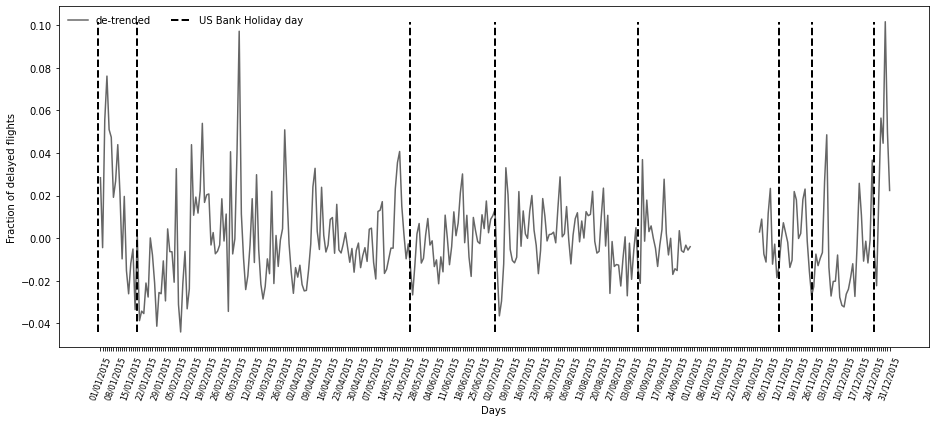

In [11]:
fig, axs = plt.subplots(figsize = (13, 6))
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.06, right = 0.99, bottom = 0.16, top = 0.95)

axs.plot(x_year, y_detrend, '-', color = 'k', alpha = 0.6, label = 'de-trended')

bank_holidays = ['01/01/2015', '19/01/2015', '25/05/2015', '03/07/2015', 
                 '07/09/2015', '11/11/2015', '26/11/2015', '25/12/2015']
date_bank_holidays = [np.where(year_2015 == bh_i)[0] for bh_i in bank_holidays]
i = 0

y_detrend[y_detrend != y_detrend] = 0.
max_val = y_detrend.max()
min_val = y_detrend.min()
for date_i in date_bank_holidays:
    if i == 0:
        axs.plot([date_i[0],date_i[0]], [min_val, max_val], 'k--', lw = 2, label = 'US Bank Holiday day')
        i+=1
    else:
        axs.plot([date_i[0],date_i[0]], [min_val, max_val], 'k--', lw = 2)


axs.set_xticks(x_year)
labels = [item.get_text() for item in axs.get_yticklabels()]
labels = year_2015
axs.tick_params(axis = 'x', labelrotation=70, labelsize = 8)
n = 7  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
axs.set_xticklabels(labels)

axs.set_ylabel('Fraction of delayed flights')
axs.set_xlabel('Days')
plt.legend(frameon = False, ncol = 2)
fig.savefig('/kaggle/working/daily_delayed_flight_bank_hol.pdf')

The bank holidays does not appear to be consistently correlated with any spikes. Instead, if any, they correspond to deeps. We note, however, that they are preceded and followed by spikes, likely to be related to people travelling around these dates. They cannot explain the large number of spikes in delays, but suggest that congestion at airports might be the reasons behind these delays. This can be further investigated by adding some regional holidays for each of the airports, and test the systematic presence of spikes around them.

With this at hands, we can suggest that congestion (either due to a bank holiday, a weekend or some holiday) is a big factor for delays in these airports. Congestion suggests that there are too many planes around. To test this we can look at the time it takes an aircraft to taxi out at a given airport whether it is delayed or not, with longer times expected at congested times.

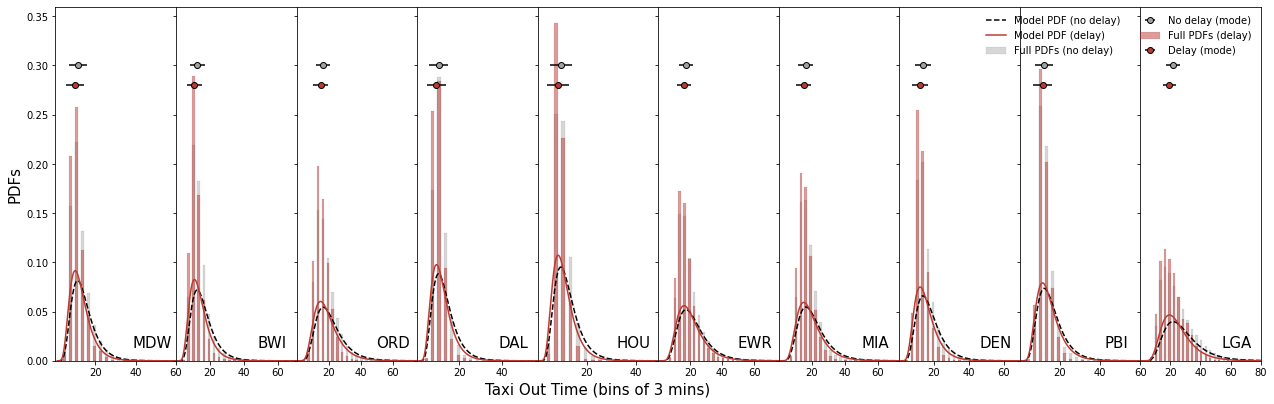

In [12]:
from scipy.optimize import minimize

# Probability density function
def modelPDF(x, mu, sigma):
    pdf = 1./sigma/np.sqrt(2.*3.14) * np.exp(-(np.log(x)-mu)**2./2./sigma**2.)
    return pdf

# Define some boundaries for the fit
bnds = ((3, 90), (1.5, 90))

# Likelihood function
def likelihood(theta, x):
    lnlike = np.log(modelPDF(x,theta[0],theta[1]))
    if -1. * lnlike.sum() != -1. * lnlike.sum():
        pdb.set_trace()
    # We add a -1 because we will be minimising
    return -1. * lnlike.sum()



fig, axs = plt.subplots(1, 10, figsize = (18, 6), sharey = True)
fig.subplots_adjust(hspace = 0.0, wspace=0., left  = 0.06, right = 0.99, bottom = 0.10, top = 0.92)
ax = axs.ravel()

x_model = np.arange(1., 100., 0.01)

for i, IATA_CODE in enumerate(IATA_CODE_DELAY):

    # Delay airport data frame sorted by date.
    df_airport = flights_delay_arrnodelay[flights_delay_arrnodelay['IATA_CODE_AIRPORT'] == IATA_CODE].sort_values(['YEAR', 'MONTH', 'DAY'])

    df_airport_nodelay = df_airport[df_airport['DEPARTURE_DELAY'] <= 15.]

    n_inbin, bins = np.histogram(df_airport_nodelay['TAXI_OUT'].values, bins = np.arange(0., 100., 3.))
    dx = (bins[1:] - bins[0:-1])/2.
    bins = bins[0:-1] +dx

    # Transform in PDFs and plot the results
    Norm = (n_inbin*dx).sum()
    ax[i].bar(bins, n_inbin/Norm, edgecolor = 'k', linewidth = 0.1, alpha = 0.5, 
             label = 'Full PDFs (no delay)', color = '#b0b0b0', width = dx)

    x0 = np.log([1., 3.])
    res_nodelay = minimize(likelihood, x0 = x0, args = df_airport_nodelay['TAXI_OUT'].values, bounds = np.log(bnds), tol = 1e-6)
    fit_pdf = modelPDF(x_model, res_nodelay['x'][0], res_nodelay['x'][1])
    Norm = np.sum(fit_pdf)*0.01
    ax[i].plot(x_model, fit_pdf/Norm, '--', color = 'k', label = 'Model PDF (no delay)')
    ax[i].errorbar(np.exp(res_nodelay['x'][0]), 0.3, xerr =  np.exp(res_nodelay['x'][1])*3.,
                   fmt = 'o', color = 'k', mfc = '#a1a1a1', label = 'No delay (mode)')




    df_airport_delay = df_airport[df_airport['DEPARTURE_DELAY'] > 15.]

    n_inbin, bins = np.histogram(df_airport_delay['TAXI_OUT'].values, bins = np.arange(0., 100., 3.))
    dx = (bins[1:] - bins[0:-1])/2.
    bins = bins[0:-1] +dx

    # Transform in PDFs and plot the results
    Norm = (n_inbin*dx).sum()
    ax[i].bar(bins, n_inbin/Norm, edgecolor = 'k', linewidth = 0.1, alpha = 0.5, 
             label = 'Full PDFs (delay)', color = '#bf3932', width = dx)


    x0 = np.log([1., 3.])
    res_delay = minimize(likelihood, x0 = x0, args = df_airport_delay['TAXI_OUT'].values, bounds = np.log(bnds), tol = 1e-6)
    fit_pdf = modelPDF(x_model, res_delay['x'][0], res_delay['x'][1])
    Norm = np.sum(fit_pdf)*0.01
    ax[i].plot(x_model, fit_pdf/Norm, '-', color = '#bf3932', label = 'Model PDF (delay)')
    ax[i].errorbar(np.exp(res_delay['x'][0]), 0.28, xerr =  np.exp(res_delay['x'][1])*3.,
                   fmt = 'o', color = 'k', mfc = '#bf3932', label = 'Delay (mode)')




    ax[i].set_xlim([0.1,np.max(df_airport_nodelay['TAXI_OUT'].values)+5.])
    plt.text(0.8, 0.05,IATA_CODE,horizontalalignment='center',
             verticalalignment='center',transform = ax[i].transAxes, fontsize = 15)



ax[i].legend(frameon = False, ncol = 2)
ax[4].set_xlabel('Taxi Out Time (bins of 3 mins)', fontsize = 15)
ax[0].set_ylabel('PDFs', fontsize = 15)
fig.savefig('/kaggle/working/taxi_out_distrib.pdf')

The histograms show the taxi out time for each of the ten airports (each panels). The grey histograms are for those aircrafts that have no departure delays, and the red histograms are for aircrafts with delays. Each histograms have been normalised so that it shows their probability density functions (PDF).

It appears that the histograms are pretty similar between the delayed and non-delayed aircrafts (large overlap between the two), suggesting that there is no differences in the taxi out time between the delayed and non-delayed aircrafts. To test this, we fit log-normal distributions - as it seems to be the shape of the PDFs - using maximum likelihood, and compare the modes and standard deviations of the delayed versus non-delayed aircrafts. Again, there is no evidence for a difference between the two, if any, it appears that the taxi out time of late aircrafts is, on average, slighty shorter, suggesting that the airport is trying to get those aircrafts back on time, and, more importantly, that the airport is able to do so.

# Conclusion
First I would like to say that I really took pleasure in doing this task, and I would have enjoyed exploring more of this dataset, trying to pin down the reasons behind these delays. There is many more routes that we could have gone down, starting from working with a weaker constraint on the delays (i.e. not just >15 mins), and splitting the airports in terms of where they are physically located to compare like-to-like. We further have completely ignore the destination airports, which can be an important factor for the delays. For instance, if an aircraft is on time, but the destination airport is congested, the aircraft might be grounded at the origin airport to avoid unecessary queues in the air at the arrival airports.

Nevertheless, with the analysis performed here, we still managed to get some crucial information about the reasons behind the delays in these airports. These are:
1. The vast majority of the delays are due to late arrival of the aircraft.
2. The seasonal changes do not appear to strongly affect the delays (i.e. adverse weather conditions).
3. Congestion at the airport due to for instance a coming bank holiday is likely to be the reasons behind delays.
4. The airfield of these airports appear to be able to cope with congestion, and do not create further delays.

All this together suggest that large delays are caused by people congestions at the airport (e.g. delay at security or check-in, or the way the aircrafts are filled with passenger), and that it has not much to do with external factors such as the weather or poor management of delayed flights on the airfield. On days prior to important dates (e.g. christmas holidays) large numbers of passengers are expected to use the airport, creating delays early on in the day. Apparently, to date, these delays are extremely difficult to catch up for airlines, creating an impression of a larger fraction of delayed flights.